In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from torch.utils.data import Dataset
import numpy as np
from sklearn.model_selection import KFold

In [2]:
def getAverageReactivies(data, className):
    return np.mean(
        [record[className] for record in data ],
        axis=0
    )

In [3]:
data = [
    json.loads(text)
    for text in open('data/train.json')
    
]
reactClasses = ['reactivity', 'deg_pH10', 'deg_Mg_pH10', 'deg_50C', 'deg_Mg_50C']
averages = {
    className: getAverageReactivies(data, className)
    for className in reactClasses
}
placeHolder = '*'
acceptableBases = ['A', 'G', 'U', 'C', placeHolder]
frameLength = 6
batchSize = 100
folds = 5
epochs = 8
learningRate = 0.0001

### Observation: the beginning and the end of the strands are a little more reactive than the middle, but other than that, the reactivies aren't really a function of their location in the sequence. This is sensible though, because, this sequence may just a subsequence of a larger sequence.

Text(0.5, 1.0, 'Average Reactivies For Each Class')

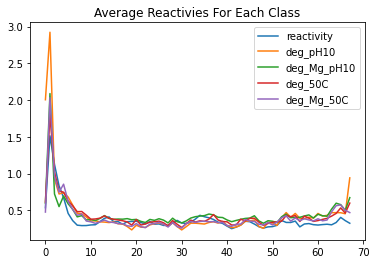

In [4]:
for className in reactClasses:
    plt.plot(averages[className], label=className)
plt.legend()
plt.title('Average Reactivies For Each Class')

In [5]:
def visualizeAverageNBases(reactivityClass):
    reactivitiesByFrame = {}
    for record in data:
        numBases = record['seq_scored']
        sequence = record['sequence']
        frames = getBaseReadingFrames(sequence[0:numBases])
        reactivities = record[reactivityClass]
        assert len(reactivities) == numBases
        assert len(frames) == numBases
        for i in range(numBases):
            if frames[i] not in reactivitiesByFrame.keys():
                reactivitiesByFrame[frames[i]] = [reactivities[i]]
            else:
                reactivitiesByFrame[frames[i]].append(reactivities[i])
    labels = [frame for frame in reactivitiesByFrame.keys()]
    averages = [ np.mean(reactivitiesByFrame[frame]) for frame in labels ]
    plt.bar(labels, averages)
    plt.title(f'Average reactivity for "{reactivityClass}" grouped by all unique reading frames of length {n}')
    plt.show()

In [6]:
def getDataSet(indices, className, useFullSequence):
    records = [ data[i] for i in indices]
    featureSets = []
    labels = []
    for record in records:
        featureSets += extractFeatureSets(record, useFullSequence)
        labels += [[reactivity] for reactivity in record[className]]
    assert len(featureSets) == len(labels), f'length of featureSets: {len(featureSets)}, length of labels: {len(labels)}'
#     print(f'sample feature set: {featureSets[0]}, sample label: {labels[0]}')
    return RNADataSet(featureSets, labels)


def extractFeatureSets(record, useFullSequence):
    if useFullSequence:
        length = record['seq_length']
    else:
        length = record['seq_scored']
        
    bases = record['sequence']
    structure = record['structure']
    encodedBaseReadingFrames = encodeBaseReadingFrames(getBaseReadingFrames(bases[:length]))
    nestDepths = getNestDepths(structure[:length])
    distances = getDistances(structure)[:length]
    clumping = [0 for i in range(length)]
    
    return [
        encodedBaseReadingFrames[i] + [i, nestDepths[i], distances[i], clumping[i]]
        for i in range(length)
    ]

In [7]:
def encodeBaseReadingFrames(frames):
    encodings = []
    for frame in frames:
        encoding = []
        for actualBase in frame:
            for possibleBase in acceptableBases:
                if actualBase == possibleBase:
                    encoding.append(1)
                else:
                    encoding.append(0)
        encodings.append(encoding)
    return encodings

def getBaseReadingFrames(sequence):
    assert frameLength < len(sequence), 'cannot have framelength greater than sequence length'
    frames = []
    for i in range(len(sequence)):
        assert sequence[i] in acceptableBases, f'{sequence[i]} is not an acceptable base'
        if i < frameLength - 1:
            numPadding = frameLength - 1 - i
            frame = ''.join([placeHolder for i in range(numPadding)]) + sequence[0:i+1]
        else:
            frame = sequence[i - frameLength + 1:i + 1]
        frames.append(frame)
    assert len(frames) == len(sequence), f'length of frames is {len(frames)}, length of sequence is {len(sequence)}'
    return frames


In [8]:
def getNestDepths(sequence):
    currentDepth = 0
    depths = []
    for i in range(len(sequence)):
        assert sequence[i] == '(' or sequence[i] == ')' or sequence[i] == '.', 'Parings must be a "(", ")", or "."'
        if sequence[i] == '(':
            currentDepth += 1
        elif i > 0 and sequence[i-1] == ')':
            currentDepth -= 1
        depths.append(currentDepth)
    return depths
    

In [9]:
def getDistances(sequence):
    distances = [0 for i in range(len(sequence))]
    completed = [False for i in range(len(sequence))]
    for i in range(len(sequence)):
        if not completed[i]:
            if sequence[i] == '.':
                completed[i] = True
            elif sequence[i] == '(':
                j = i + 1
                numParen = 0
                while not (sequence[j] == ')' and numParen == 0):
                    if sequence[j] == '(':
                        numParen += 1
                    elif sequence[j] == ')':
                        numParen -= 1
                    j += 1
                    assert j < len(sequence), 'ill-formed sequence: j is beyond the max index'
                distance = j - i
                distances[i] = distance
                distances[j] = distance
                completed[i] = True
                completed[j] = True
    return distances
                    
            
            

In [10]:
def train(model, optimizer, criteria, trainLoader, valLoader):
    trainLoss = []
    valLoss = []
    for epoch in range(epochs):
        
        # ****** Training *******
        model.train()
        losses = []
        for features, labels in trainLoader:
            optimizer.zero_grad()
            output = model(features)
            loss = criteria(output, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        trainLoss.append(np.mean(losses))
        
        # ****** Validation *******
        model.eval()
        losses = []
        with torch.no_grad():
            for features, labels in valLoader:
                optimizer.zero_grad()
                output = model(features)
                loss = criteria(output, labels)
                losses.append(loss.item())
            valLoss.append(np.mean(losses))
    return trainLoss, valLoss

In [11]:
class RNADataSet(Dataset):
    def __init__(self, features, labels):
        self.features = torch.from_numpy(np.array(features)).float()
        self.labels = torch.from_numpy(np.array(labels)).float()
    
    def __len__(self):
        return len(self.features)
    
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

entering cross validation training


/home/abeeston/.local/share/virtualenvs/dataScience-GZHB9V2k/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Fold 1 last-epoch training: 0.4832, validation: 0.451


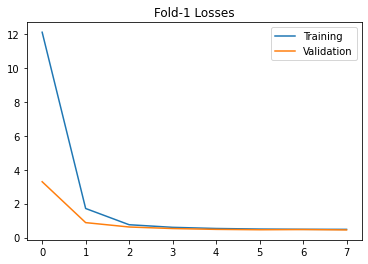

Fold 2 last-epoch training: 0.47, validation: 0.4912
Fold 3 last-epoch training: 0.4948, validation: 0.4
Fold 4 last-epoch training: 0.4836, validation: 0.4384
Fold 5 last-epoch training: 0.4455, validation: 0.5931


In [12]:
className = 'reactivity'
splitter = KFold(folds)
allTrainLosses = []
allValLosses = []
foldCounter = 1
print('entering cross validation training')
useFullSequence = False
for trainIndices, valIndices in splitter.split(data):
    trainData = getDataSet(trainIndices, className, useFullSequence)
    valData = getDataSet(valIndices, className, useFullSequence)
    trainLoader = DataLoader(trainData, batch_size=batchSize, shuffle=True)
    valLoader = DataLoader(valData, batch_size=batchSize, shuffle=True)
    numFeatures = len(trainData[0][0])
    model = torch.nn.Linear(numFeatures, 1)
    criteria = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    trainLosses, valLosses = train(model, optimizer, criteria, trainLoader, valLoader)
    allTrainLosses.append(trainLosses)
    allValLosses.append(valLosses)
    print(f'Fold {foldCounter} last-epoch training: {round(trainLosses[-1], 4)}, validation: {round(valLosses[-1], 4)}')
    if foldCounter == 1:
        plt.title('Fold-1 Losses')
        plt.plot(trainLosses, label='Training')
        plt.plot(valLosses, label='Validation')
        plt.legend()
        plt.show()
    foldCounter += 1

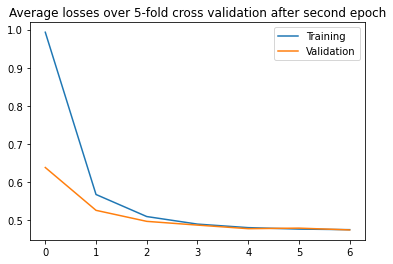

Final average training loss: 0.4754
Final average validation loss: 0.4748


In [13]:
# print(allTrainLosses)
# print(allValLosses)
startingEpoch = 1
averageTrainLosses = []
averageValLosses = []
for i in range(epochs)[startingEpoch:]:
    averageTrainLosses.append(np.mean([loss[i] for loss in allTrainLosses]))
    averageValLosses.append(np.mean([loss[i] for loss in allValLosses]))
plt.plot(averageTrainLosses, label='Training')
plt.plot(averageValLosses, label='Validation')
plt.title(f'Average losses over {folds}-fold cross validation after second epoch')
plt.legend()
plt.show()
print(f'Final average training loss: {round(averageTrainLosses[-1], 4)}')
print(f'Final average validation loss: {round(averageValLosses[-1], 4)}')